# introduction
- given: many unlabeled data points and few labeled data points of a class $C$ known to be a minority
- goal: correctly label as many data points of $C$ and hard negatives from the other class with as few effort as necessary
- hard negatives: members from other class that are hard to distinguish from $C$
- method: Positive Unlabeled Learning (given: labeled data points of positive class and unlabeled data points from both classes; iteratively label most confident predictions as members of positive class; here supported by costly manual checks)

In [1]:
import numpy as np
from sklearn import datasets
import copy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score

# Load Forest Covertypes dataset
forest = datasets.fetch_covtype()
x = forest.data
y = forest.target
y_gt = np.zeros_like(y)
y_gt[np.where(y == 1)[0]] = 1
ids_pos_gt = np.where(y_gt == 1)[0]

In [2]:
n = 10_000  # training data points
share_pos_labeled = 0.1  # share of labeled members of positive class
n_iters = 100  # max iteration
n_forward = 100  # amount of labeling candidates per iteration

x_train = x[:n]
y_gt_train = y_gt[:n]
y_train = np.zeros_like(y_gt_train)
n_labeled = len(np.where(y_gt_train == 1)[0])
y_train[np.where(y_gt_train == 1)[0][:int(n_labeled * share_pos_labeled)]] = 1
y_train_init = copy.deepcopy(y_train)

x_test = x[n:n + n]
y_test = y_gt[n:n + n]

clf = RandomForestClassifier()
f1s = []
manual_checks = []
pos_finds = []
ids_neg = []
for i in range(n_iters):
    # train (and predict on test to further evaluate model)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    f1 = f1_score(y_pred=pred, y_true=y_test)
    f1s.append(f1)

    # set label of data point with most confident positive prediction to 1
    # ignore indices, where label is already known to be 1
    # ignore indices where label is already known to be 0
    probas = clf.predict_proba(x_train)[:, 1]
    ids_max = np.argsort(probas)[::-1]
    ids_max = [id for id in ids_max if (id not in np.where(y_train == 1)[0]) and (id not in ids_neg)]
    ids_max = ids_max[:min(len(ids_max), n_forward)]
    manual_checks.append(len(ids_max))
    
    # manual check (costly):
    ids_pos = [id for id in ids_max if id in ids_pos_gt]
    pos_finds.append(len(ids_pos))
    ids_neg.extend([id for id in ids_max if id not in ids_pos_gt])

    # fix new labels
    y_train[ids_pos] = 1

    # converge if either no more data points to check or all positives are found
    if recall_score(y_pred=y_train, y_true=y_gt_train) == 1:
        break
    if len(ids_max) == 0:
        break
print(manual_checks)
print(pos_finds)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[20, 25, 45, 44, 53, 47, 68, 59, 58, 51, 46, 48, 30, 32, 20, 19, 19, 16, 31, 57, 42, 28, 37, 50, 49, 49, 42, 32, 34, 28, 10, 6, 2, 4, 5, 4, 3, 5, 3, 0, 4, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2, 0, 1]


In [3]:
# random run for comparison
n = 10_000
share_pos_labeled = 0.1
n_iters = 100
n_forward = 100

x_train = x[:n]
y_gt_train = y_gt[:n]
y_train = np.zeros_like(y_gt_train)
n_labeled = len(np.where(y_gt_train == 1)[0])
y_train[np.where(y_gt_train == 1)[0][:int(n_labeled * share_pos_labeled)]] = 1
y_train_init = copy.deepcopy(y_train)

x_test = x[n:n + n]
y_test = y_gt[n:n + n]

manual_checks_random = []
pos_finds_random = []
ids_neg = []
for i in range(n_iters):
    probas = np.random.random(size=len(y_train))
    ids_max = np.argsort(probas)[::-1]
    ids_max = [id for id in ids_max if (id not in np.where(y_train == 1)[0]) and (id not in ids_neg)]
    ids_max = ids_max[:min(len(ids_max), n_forward)]
    manual_checks_random.append(len(ids_max))
    ids_pos = [id for id in ids_max if id in ids_pos_gt]
    pos_finds_random.append(len(ids_pos))
    ids_neg.extend([id for id in ids_max if id not in ids_pos_gt])
    y_train[ids_pos] = 1
    if recall_score(y_pred=y_train, y_true=y_gt_train) == 1:
        break
    if len(ids_max) == 0:
        break

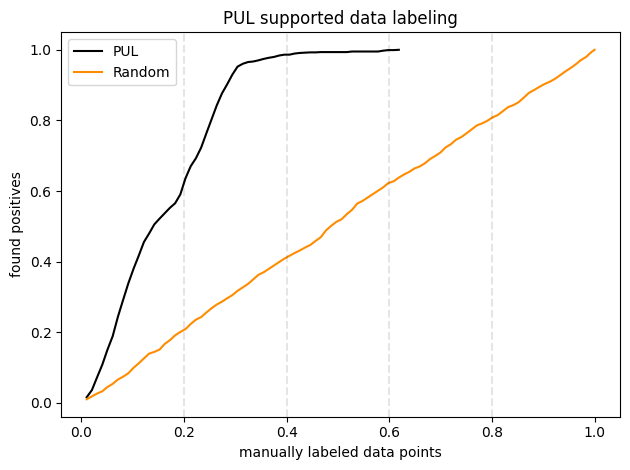

In [4]:
import matplotlib.pyplot as plt


# random baseline
manual_checks_random_cumul = [manual_checks_random[0]]
for i in range(1, len(manual_checks_random)):
    manual_checks_random_cumul.append(manual_checks_random_cumul[i - 1] + manual_checks_random[i])
max_manual_checks = max(manual_checks_random_cumul)
manual_checks_random_cumul = [i / max_manual_checks for i in manual_checks_random_cumul]

pos_finds_random_cumul = [pos_finds_random[0]]
for i in range(1, len(pos_finds_random)):
    pos_finds_random_cumul.append(pos_finds_random_cumul[i - 1] + pos_finds_random[i])
pos_finds_random_cumul = [i / max(pos_finds_random_cumul) for i in pos_finds_random_cumul]


# proposed method
manual_checks_cumul = [manual_checks[0]]
for i in range(1, len(manual_checks)):
    manual_checks_cumul.append(manual_checks_cumul[i - 1] + manual_checks[i])
manual_checks_cumul = [i / max_manual_checks for i in manual_checks_cumul]

pos_finds_cumul = [pos_finds[0]]
for i in range(1, len(pos_finds)):
    pos_finds_cumul.append(pos_finds_cumul[i - 1] + pos_finds[i])
pos_finds_cumul = [i / max(pos_finds_cumul) for i in pos_finds_cumul]

plt.plot(manual_checks_cumul, pos_finds_cumul, label="PUL", c="black")
plt.plot(manual_checks_random_cumul, pos_finds_random_cumul, label="Random", c="darkorange")
plt.xlabel("manually labeled data points")
plt.ylabel("found positives")
plt.title("PUL supported data labeling")
plt.axvline(x=0.2, color='black', alpha=0.1, linestyle='--')
plt.axvline(x=0.4, color='black', alpha=0.1, linestyle='--')
plt.axvline(x=0.6, color='black', alpha=0.1, linestyle='--')
plt.axvline(x=0.8, color='black', alpha=0.1, linestyle='--')
plt.legend()
plt.tight_layout()

PUL-supported manually labeling ~ 35% of the data points leads to finding ~ 95% of the positive members,
while finding the same amount of positive members (and likely less hard negatives) with random manual labeling demands seeing 95% of the data points

Text(0, 0.5, 'f1')

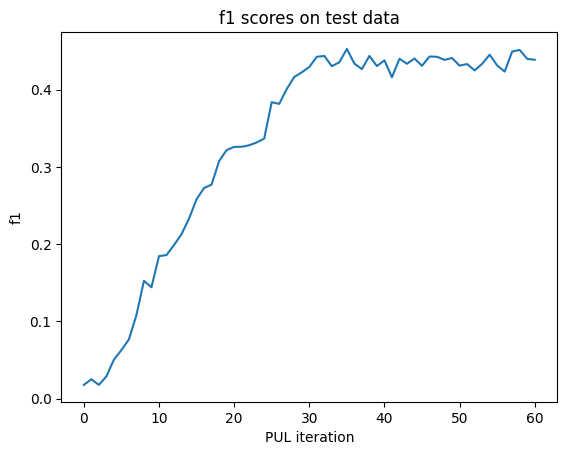

In [5]:
plt.plot(range(len(f1s)), f1s)
plt.title("f1 scores on test data")
plt.xlabel("PUL iteration")
plt.ylabel("f1")

furthermore, leveraging more labels drastically improves the models f1 score on test data